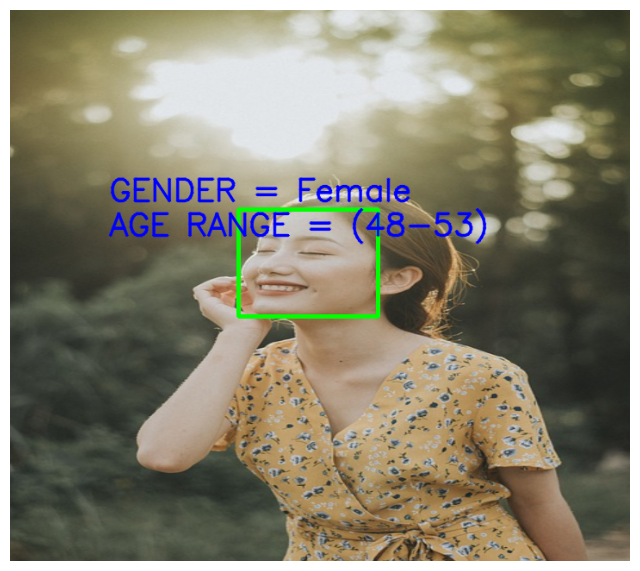

In [15]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread('female1.jpg')
test = cv2.resize(test, (720, 640))

face_pt = "opencv_face_detector.pbtxt"
face_wg = "opencv_face_detector_uint8.pb"
age_pt = "age_deploy.prototxt"
age_wg = "age_net.caffemodel"
gender_pt = "gender_deploy.prototxt"
gender_wg = "gender_net.caffemodel"

mean_values = (78.426, 87.769, 114.896)

face_dt = cv2.dnn.readNet(face_wg, face_pt)
age_pd = cv2.dnn.readNet(age_wg, age_pt)
gender_pd = cv2.dnn.readNet(gender_wg, gender_pt)

age_range = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
               '(25-32)', '(38-43)', '(48-53)', '(60-100)']
gender_class = ['Male', 'Female']

processing_img = test.copy()

img_ht, img_wd = processing_img.shape[:2]
image_blob = cv2.dnn.blobFromImage(processing_img, 1.0, (300, 300),
                                   [104, 117, 123], swapRB=True, crop=False)

face_dt.setInput(image_blob)
detections = face_dt.forward()

faces = []
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.7:
        x1 = int(detections[0, 0, i, 3] * img_wd)
        y1 = int(detections[0, 0, i, 4] * img_ht)
        x2 = int(detections[0, 0, i, 5] * img_wd)
        y2 = int(detections[0, 0, i, 6] * img_ht)
        faces.append([x1, y1, x2, y2])
        cv2.rectangle(processing_img, (x1, y1), (x2, y2),
                      (0, 255, 0), int(round(img_ht / 150)), 2)

if not faces:
    print("No faces detected.")

for box in faces:
    face_region = processing_img[max(0, box[1] - 15):
                                 min(box[3] + 15, processing_img.shape[0] - 1),
                                 max(0, box[0] - 15):min(box[2] + 15, processing_img.shape[1] - 1)]

    face_blob = cv2.dnn.blobFromImage(face_region, 1.0, (227, 227),
                                     mean_values, swapRB=False, crop=False)

    gender_pd.setInput(face_blob)
    gender_probs = gender_pd.forward()
    gender = gender_class[gender_probs[0].argmax()]

    age_pd.setInput(face_blob)
    age_probs = age_pd.forward()
    age = age_range[age_probs[0].argmax()]

    cv2.putText(processing_img, f'GENDER = {gender}', (box[0] - 150, box[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(processing_img, f'AGE RANGE = {age}', (box[0] - 150, box[1] + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(processing_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
